In [1]:
!CUDA_VISIBLE_DEVICE=0

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE

UMAP

In [3]:
def load_VAE():
    autoencoder = VAE(
        num_genes=18996,
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint/muris_scimilarity_lognorm_finetune/model_seed=0_step=150000.pt'))
    return autoencoder

real data

In [4]:
adata = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/tabula_muris/all.h5ad')

adata = adata[np.where(adata.obs['celltype'].values.isnull()==0)[0]][::5]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

gene_names = adata.var_names

celltype = adata.obs['celltype']
cell_data = adata.X.toarray()
cell_data.shape

/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


(11401, 18996)

unconditional generated data

In [5]:
npzfile=np.load('/data1/lep/Workspace/guided-diffusion/output/muris_scimilarity.npz',allow_pickle=True)
cell_gen_all = npzfile['cell_gen'][::5]

autoencoder = load_VAE()
cell_gen = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

cell_gen.shape

(12000, 18996)

conditional generated data

In [ ]:
# if not generated all type of cells, use the real cell to balance the batchnorm in the scimilarity
adata_w = adata.copy()[::5]
adata_w.var_names = gene_names

autoencoder = load_VAE()
cell_w = autoencoder(torch.tensor(adata_w.X).cuda(),return_latent=True).detach().cpu().numpy()

# concat this cell_w with cell_gen and send them to the autoencoder
# cell_gen_all = autoencoder(torch.tensor(np.concatenate((cell_gen,cell_w),axis=0)).cuda(),return_decoded=True).cpu().detach().numpy()
cell_w.shape

In [6]:
cell_gen_all = []
gen_class = []
cato = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']
index2 = [0,1,2,3,4,5,6,7,8,9,10,11]
for i in index2:
    npzfile=np.load(f'/data1/lep/Workspace/guided-diffusion/output/muris_condi/muris_{i}_scimilarity.npz',allow_pickle=True)
    length = min(adata[adata.obs['celltype']==cato[i]].X.shape[0],6000)
    cell_gen_all.append(npzfile['cell_gen'][:int(length)])#.squeeze(1)

    gen_class+=['gen '+cato[i]]*int(length)

cell_gen_all = np.concatenate(cell_gen_all,axis=0)

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

cell_gen = cell_gen_all
cell_gen.shape

(11401, 18996)

plot UMAP

In [7]:
adata = np.concatenate((cell_data, cell_gen),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)

adata.obs['celltype'] = np.concatenate((celltype, gen_class))
adata.obs['cell_name'] = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]

In [8]:
# the data is already log norm
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


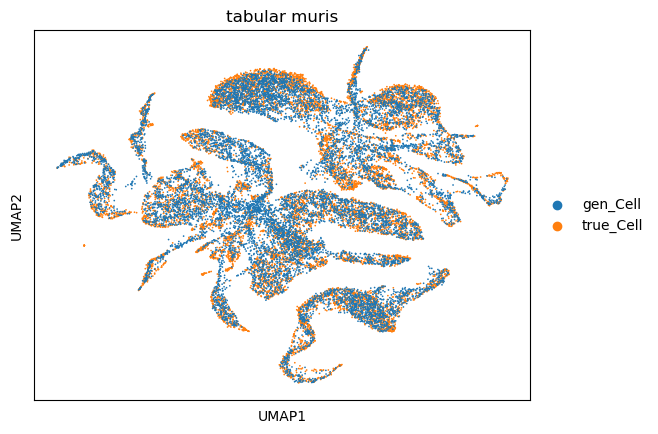

In [9]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata=adata,color="cell_name",size=6,title='tabular muris')

draw plot of each cell type if conditional generation

/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/sc

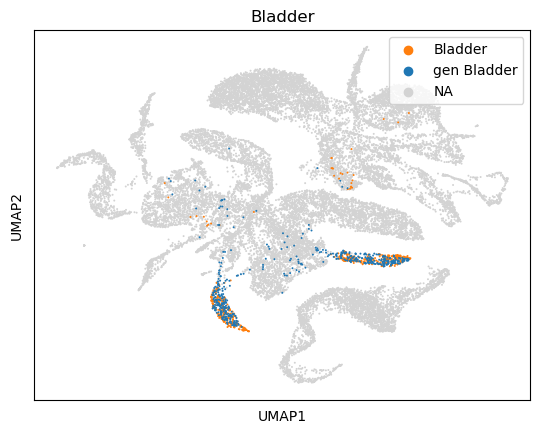

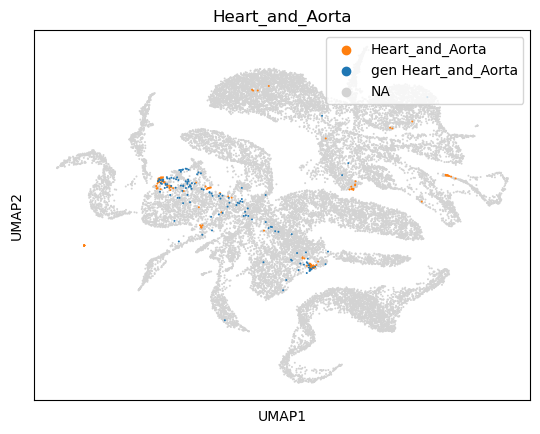

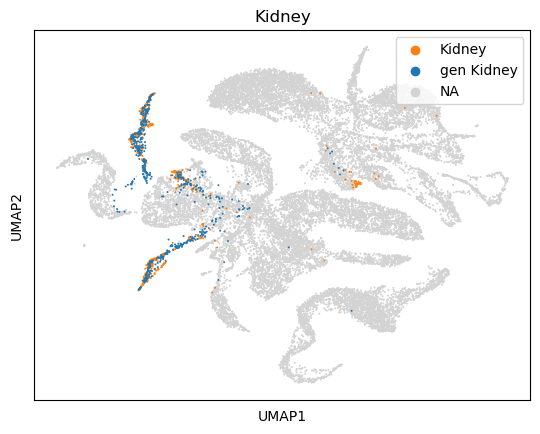

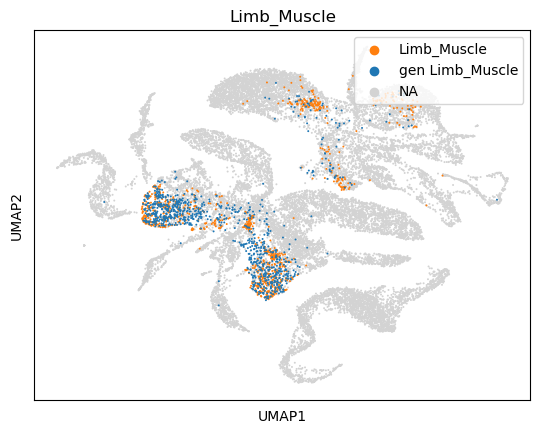

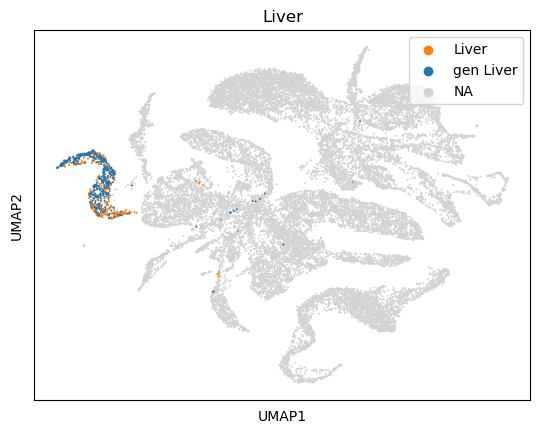

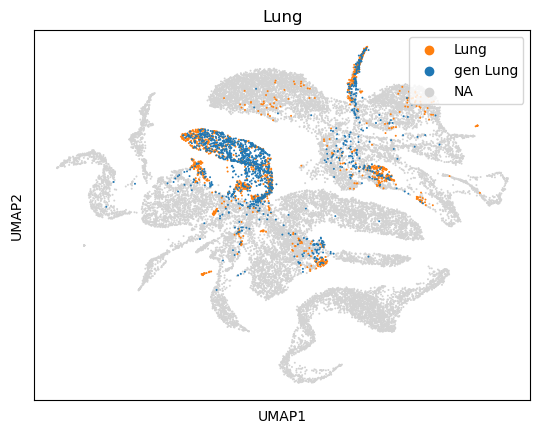

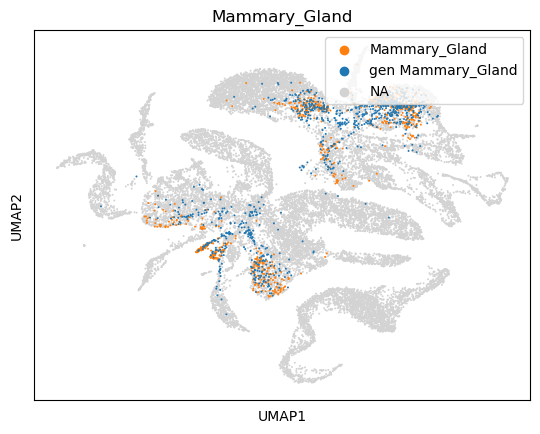

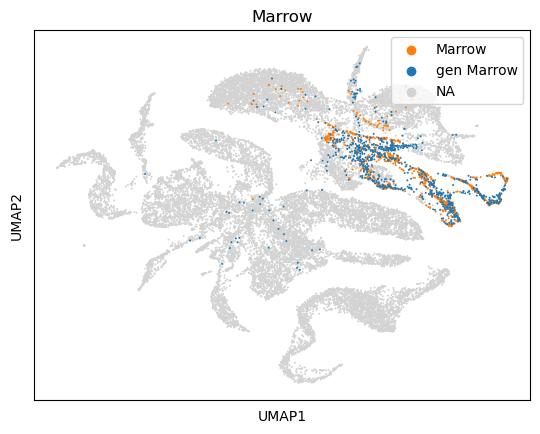

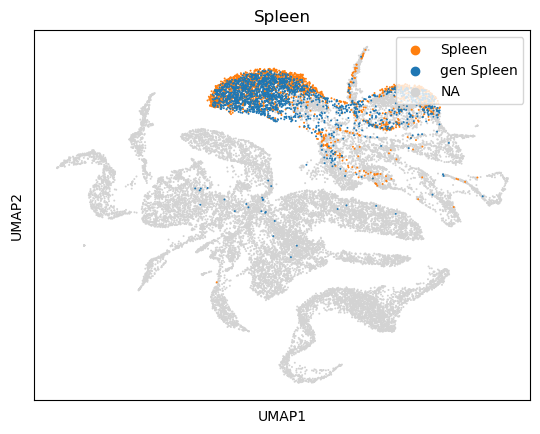

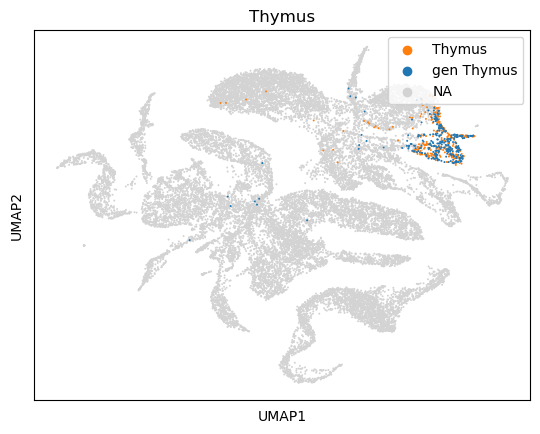

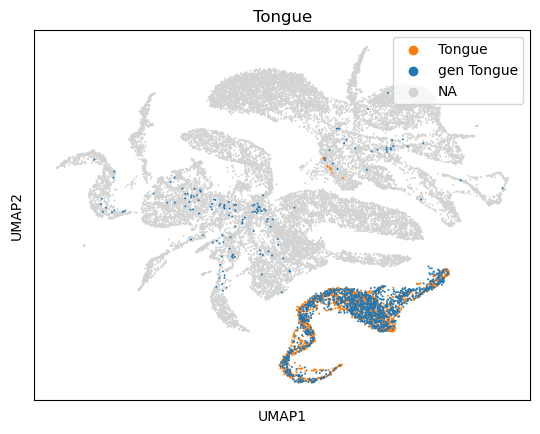

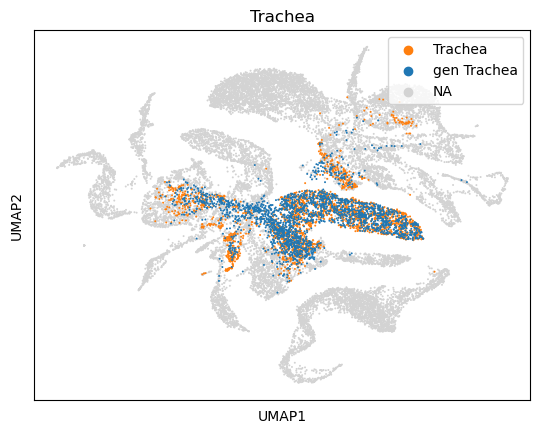

In [10]:
for categoray in cato:
    color_dict = {}
    for cat in adata.obs['celltype'].cat.categories:
        if cat == categoray:
            color_dict[cat] = 'tab:orange'
        elif cat == 'gen '+categoray:
            color_dict[cat] = 'tab:blue'
        else:
            color_dict[cat] = 'black'
    sc.pl.umap(adata=adata,color="celltype",groups=[categoray,'gen '+categoray],size=8, palette=color_dict, show = False)
    plt.legend(loc = 'upper right')
    plt.title(categoray)